
# Optimization & Feedback Loops in Modeling
*A practical introduction to monitoring, drift, and continuous improvement*

## 🎯 Learning Goals
- Understand closed-loop ML systems and why feedback matters
- Simulate a **non-stationary** world where relationships change over time
- Compare: **static model** vs **periodic retraining** vs **online learning**
- Monitor with rolling metrics and **drift checks**
- See how simple **bandit-style exploration** fuels better data



## 1️⃣ What is a Feedback Loop?
A **feedback loop** means model outputs influence future data collection.  
Examples:
- A recommendation model changes what users see → which changes what they click.
- A pricing model changes price → which changes sales → which changes future training data.

**Implications**
- You must **monitor** models (data + metrics) in production.
- Expect **drift**: the world changes; retraining is necessary.
- Use **safe exploration** to avoid getting stuck in local optima.



## 2️⃣ Simulation: Non-Stationary Environment
We'll simulate weekly data where the sales relationship **shifts mid-stream** (e.g., seasonality, competition).  
Features:
- `price`, `ad_spend`
- Target: `sales`


We split the stream into **batches** (weeks). We'll track performance for:
1. **Static model**: trained once, never updated
2. **Periodic retrain**: retrain every *k* batches
3. **Online learning**: incremental updates with `partial_fit`


In [1]:

import numpy as np
import pandas as pd

rng = np.random.default_rng(123)

def simulate_stream(n_batches=40, batch_size=100, shift_at=20):
    data = []
    for b in range(n_batches):
        # features
        price = rng.normal(20, 3, batch_size).clip(5)
        ad_spend = rng.normal(8, 2.5, batch_size).clip(0)
        # world changes after shift_at
        if b < shift_at:
            sales = 6 - 1.0*price + 2.5*ad_spend + rng.normal(0, 2.0, batch_size)
        else:
            # price becomes less elastic, ads more effective
            sales = 6 - 0.6*price + 3.2*ad_spend + 4.0 + rng.normal(0, 2.0, batch_size)
        data.append(pd.DataFrame({"batch": b, "price": price, "ad_spend": ad_spend, "sales": sales}))
    return pd.concat(data, ignore_index=True)

stream_df = simulate_stream()
stream_df.head()


,batch,price,ad_spend,sales
0,0,17.032636,6.710581,3.869683
1,0,18.896640,12.145283,15.847892
2,0,23.863776,7.256844,-0.545930
3,0,20.581923,4.541557,-1.545845
4,0,22.760693,7.296989,4.795140



## 3️⃣ Three Strategies
- **Static**: Train on first few batches; keep fixed weights.
- **Periodic**: Retrain every `k` batches on **all data so far**.
- **Online**: Update incrementally each batch with `partial_fit`.

We'll evaluate **MAE per batch** to visualize degradation and recovery.


In [2]:

from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_absolute_error

# Prepare batches
batches = [stream_df[stream_df.batch == b].reset_index(drop=True) for b in sorted(stream_df.batch.unique())]

# Initial training window
init_window = 5
X0 = pd.concat([batches[i][["price","ad_spend"]] for i in range(init_window)])
y0 = pd.concat([batches[i]["sales"] for i in range(init_window)])

# Models
static = LinearRegression().fit(X0, y0)
periodic = LinearRegression().fit(X0, y0)
online = SGDRegressor(random_state=42, max_iter=1, learning_rate="optimal", eta0=0.01)
online.partial_fit(X0, y0)  # initialize

k_retrain = 5  # retrain every k batches (periodic)

mae_static, mae_periodic, mae_online = [], [], []

X_hist = X0.copy()
y_hist = y0.copy()

for b in range(init_window, len(batches)):
    Xb = batches[b][["price","ad_spend"]]
    yb = batches[b]["sales"]
    
    # predictions
    p_static = static.predict(Xb)
    p_periodic = periodic.predict(Xb)
    p_online = online.predict(Xb)
    
    # errors
    mae_static.append(mean_absolute_error(yb, p_static))
    mae_periodic.append(mean_absolute_error(yb, p_periodic))
    mae_online.append(mean_absolute_error(yb, p_online))
    
    # update periodic (retrain every k)
    X_hist = pd.concat([X_hist, Xb])
    y_hist = pd.concat([y_hist, yb])
    if (b % k_retrain) == 0:
        periodic.fit(X_hist, y_hist)
    
    # online update every batch
    online.partial_fit(Xb, yb)

(len(mae_static), len(mae_periodic), len(mae_online))


(35, 35, 35)


### MAE per Batch (Lower is Better)


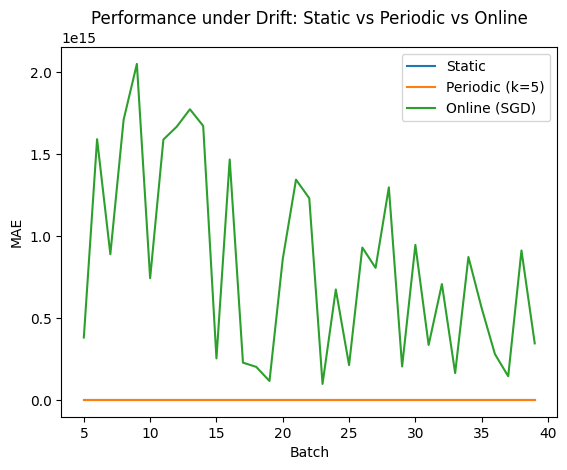

In [3]:

import matplotlib.pyplot as plt

xs = list(range(init_window, len(batches)))
plt.figure()
plt.plot(xs, mae_static, label="Static")
plt.plot(xs, mae_periodic, label=f"Periodic (k={5})")
plt.plot(xs, mae_online, label="Online (SGD)")
plt.xlabel("Batch")
plt.ylabel("MAE")
plt.title("Performance under Drift: Static vs Periodic vs Online")
plt.legend()
plt.show()



## 4️⃣ Monitoring & Drift Detection
Production systems track **data** and **prediction** health:
- **Input drift** (feature distribution changes)
- **Prediction drift / label drift**
- **Performance** (MAE, MAPE, RMSE, AUC, etc.)

We'll compute a simple **Population Stability Index (PSI)** for `ad_spend` across batches vs. the reference distribution (first window).


In [4]:

def psi(expected, actual, buckets=10):
    e_bins = np.quantile(expected, np.linspace(0,1,buckets+1))
    # avoid duplicates in bins by adding tiny jitter
    e_bins = np.unique(e_bins)
    if len(e_bins) <= 2:
        return 0.0
    e_counts, _ = np.histogram(expected, bins=e_bins)
    a_counts, _ = np.histogram(actual, bins=e_bins)
    e_perc = e_counts / max(e_counts.sum(), 1)
    a_perc = a_counts / max(a_counts.sum(), 1)
    # replace zeros
    e_perc = np.clip(e_perc, 1e-6, None)
    a_perc = np.clip(a_perc, 1e-6, None)
    return float(np.sum((a_perc - e_perc) * np.log(a_perc / e_perc)))

ref = X0["ad_spend"].values
psis = []
for b in range(init_window, len(batches)):
    cur = batches[b]["ad_spend"].values
    psis.append(psi(ref, cur, buckets=10))

len(psis), psis[:5]


(35,
 [0.0960643343695857,
  0.09613110771278158,
  0.15502202097959214,
  0.0728452555895924,
  0.053899928308560247])


### PSI over Time
**Heuristic thresholds** (varies by org):  
- `< 0.1` minimal shift, `0.1–0.25` moderate, `> 0.25` significant.


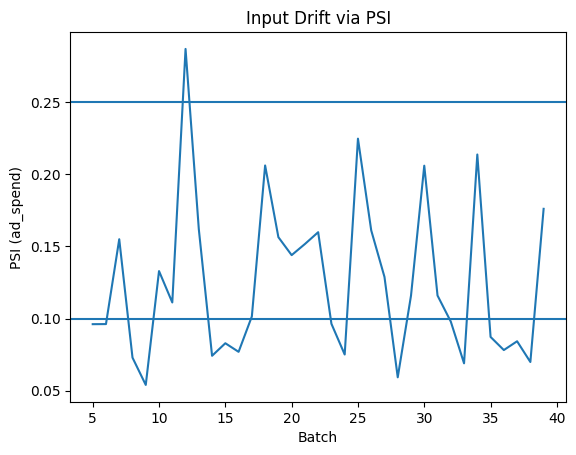

In [5]:

plt.figure()
plt.plot(xs, psis)
plt.axhline(0.1)
plt.axhline(0.25)
plt.xlabel("Batch")
plt.ylabel("PSI (ad_spend)")
plt.title("Input Drift via PSI")
plt.show()



## 5️⃣ Exploration via a Simple Bandit
If you **only exploit** current best action (e.g., always same ad spend), you collect biased data.  
We'll simulate **ε-greedy** selection of `ad_spend` levels to learn better over time.


In [6]:

# Discretize ad_spend into arms; choose one each step
arms = np.array([2, 5, 8, 11, 14], dtype=float)
epsilon = 0.1
n_steps = 400

# world response (changes halfway)
def world_reward(price, ad_spend, t):
    rng = np.random.default_rng(t+77)
    if t < n_steps//2:
        sales = 6 - 1.0*price + 2.5*ad_spend + rng.normal(0, 2.0)
    else:
        sales = 10 - 0.6*price + 3.2*ad_spend + rng.normal(0, 2.0)
    return sales

# learn average reward per arm
est = np.zeros_like(arms, dtype=float)
counts = np.zeros_like(arms, dtype=int)
price_fixed = 20.0

rewards = []
for t in range(n_steps):
    if np.random.rand() < epsilon:
        idx = np.random.randint(len(arms))          # explore
    else:
        idx = int(np.argmax(est))                   # exploit
    a = arms[idx]
    r = world_reward(price_fixed, a, t)
    counts[idx] += 1
    est[idx] += (r - est[idx]) / counts[idx]        # incremental mean
    rewards.append(r)

len(rewards), float(np.mean(rewards))


(400, 29.306644972376525)


### Bandit Reward over Time


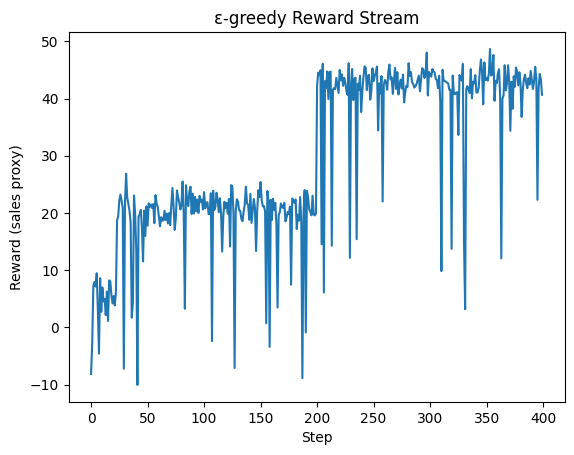

In [7]:

plt.figure()
plt.plot(rewards)
plt.xlabel("Step")
plt.ylabel("Reward (sales proxy)")
plt.title("ε-greedy Reward Stream")
plt.show()



## 6️⃣ Practical Monitoring Checklist
- **Data**: schema, nulls, ranges, drift (PSI, KL), freshness
- **Predictions**: distribution, drift vs training
- **Performance**: rolling MAE/RMSE/AUC with confidence bands
- **Infra**: latency, error rates, throughput
- **Retraining policy**: time-based, trigger-based (drift/perf thresholds), or hybrid
- **Experimentation**: A/B tests or bandits to balance learning vs revenue risk
- **Logging**: versioned models, features, config, and outcomes for auditability



## 7️⃣ Takeaways
- The world changes. Build **monitoring + retraining** into your lifecycle.
- **Online or frequent updates** mitigate drift.
- **Explore safely** to avoid blind spots and collect better data.
